In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import json
from huggingface_hub import login

# Read the JSON config file
with open('config.json', 'r') as f:
    config = json.load(f)

# Get the token from the JSON file
hg_token = config['HuggingFace']['token']
# Login using the token
login(token=hg_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /PHShome/cs1839/.cache/huggingface/token
Login successful


# Result

In [28]:
import pandas as pd
import json
import re
import numpy as np

# Data folder
data_folder = "/PHShome/cs1839/capstone_data/"
# Results table path
results_df_path = data_folder + "results.csv"

# Load the results data
result_df = pd.read_csv(results_df_path).round(3)
result_df = result_df[result_df['Dataset'] != 'MIMIC-IV']
# load gpt-4o result
gpt_results = pd.read_csv(data_folder + "results_gpt4o.csv").round(3)
# load mimic-iv result
mimic_iv_results = pd.read_csv(data_folder + "results_mimic_iv_new.csv").round(3)
# load_internal_data_results
internal_data_results = pd.read_csv(data_folder + "internal_data_results_updated.csv").round(3)
# concat the gpt-4o results
result_df = pd.concat([result_df, gpt_results, mimic_iv_results, internal_data_results], ignore_index=True)

# Read the prompts.json file
with open('prompts.json') as f:
    prompts_json = json.load(f)

# Create a mapping from prompt to its key name
prompt_to_key_map = {value: key for key, value in prompts_json.items()}

# Define a function to extract the method from the prompt key
def get_method_from_prompt(prompt):
    key = prompt_to_key_map.get(prompt, None)
    if key:
        if len(key.split('_')) > 1:
            return '_'.join(key.split('_')[1:])  # Get the method from the second position
        else:
            return '0-Shot'
    return 'Unknown'  # Assign 'Unknown' if the key is not found

# Assign the 'Method' column based on the prompt key
result_df['Method'] = result_df['Prompt'].apply(get_method_from_prompt)

# replace 1_shot_1, 1_shot_2, 1_shot_3, 1_shot_4, 1_shot_5 with `1-Shot`, there is existence of 1_shot_CoT, which is not a one-shot prompt
result_df['Method'] = result_df['Method'].apply(lambda x: re.sub(r'1_shot_([1-5])(?!_CoT)', '1-Shot', x))
result_df['Method'] = result_df['Method'].apply(lambda x: re.sub(r'1_shot_([1-5])_CoT', '1-Shot & CoT', x))
result_df['Method'] = result_df['Method'].apply(lambda x: re.sub(r'5_shots(?!_CoT)', '5-Shot', x))
result_df['Method'] = result_df['Method'].apply(lambda x: re.sub(r'5_shots_CoT', '5-Shot & CoT', x))

# Filter one-shot results and calculate averages for one-shot prompts
result_df = result_df.groupby(['Dataset', 'Model', 'Method']).agg({
    # calcualte the mean and standard deviation for the following columns
    'extraction_precision': ['mean','std'],
    'extraction_recall': ['mean','std'],
    'extraction_f1': ['mean','std'],
    
    'accuracy_w_gt':['mean','std'],
    'macro_f1_w_gt': ['mean','std'],
    'macro_precision_w_gt': ['mean','std'],
    'macro_recall_w_gt': ['mean','std'],

    'joint_accuracy': ['mean','std'],
    'joint_macro_f1':['mean','std'],
    'joint_macro_precision': ['mean','std'],
    'joint_macro_recall':['mean','std'],
}).reset_index().round(3)

# Append new GPT results
gpt_results = pd.DataFrame([
    {
        # 'Prompt': 'Create a bulleted list of which medications are mentioned and whether they are active, discontinued, or neither.',
        'Dataset': 'MIT',
        'Model': 'GPT-3 + R (32 LOC)',
        'Method': '0-Shot',
        'joint_macro_f1': '--',
        'joint_accuracy': '--',
        # 'extraction_precision': 0.87,
        # 'extraction_recall': 0.83,
        'extraction_f1': round(2 * 0.87 * 0.83 / (0.87 + 0.83), 3),
        # 'conditional_accuracy': 0.85,
        # 'conditional_macro_f1': 0.69,
        # 'conditional_macro_precision': '--',
        # 'conditional_macro_recall': '--',
        'macro_f1_w_gt': '--',
        'accuracy_w_gt': '--',
        'extraction_f1_mean': np.nan,
        'accuracy_w_gt_mean': np.nan,
        'macro_f1_w_gt_mean': np.nan,
        'joint_accuracy_mean': np.nan,
        'joint_macro_f1_mean': np.nan,
    },
    {
        # 'Prompt': 'Create a bulleted list of which medications are mentioned and whether they are active, discontinued, or neither.',
        'Dataset': 'MIT',
        'Model': 'GPT-3 + R (8 LOC)',
        'Method': '1-Shot',
        'joint_macro_f1': '--',
        'joint_accuracy': '--',
        # 'extraction_precision': 0.90,
        # 'extraction_recall': 0.92,
        'extraction_f1': round(2 * 0.90 * 0.92 / (0.90 + 0.92), 3),
        # 'conditional_accuracy': 0.89,
        # 'conditional_macro_f1': 0.62,
        # 'conditional_macro_precision': '--',
        # 'conditional_macro_recall': '--',
        'macro_f1_w_gt': '--',
        'accuracy_w_gt': '--',
        'extraction_f1_mean': np.nan,
        'accuracy_w_gt_mean': np.nan,
        'macro_f1_w_gt_mean': np.nan,
        'joint_accuracy_mean': np.nan,
        'joint_macro_f1_mean': np.nan,
    }
])


pd.set_option('display.max_rows', None)
# reset the multi-level index with appending the column names, ignore Dataset, Model, Method
result_df.columns = ['_'.join(col).strip() if col[0] not in ['Dataset', 'Model', 'Method'] else col[0] for col in result_df.columns.values]
# combine the mean and std by having new columns of mean ± std
for col in ['extraction_f1', 'accuracy_w_gt', 'macro_f1_w_gt', 'joint_accuracy', 'joint_macro_f1']:
    result_df[col] = result_df[col + '_mean'].round(3).astype(str) + ' ± ' + result_df[col + '_std'].astype(str)
# drop all columns with  _std
result_df = result_df.drop(columns=[col for col in result_df.columns if '_std' in col])

# Sort the final results by Method, Dataset, and extraction_f1
col_to_include = ['Dataset', 'Model', 'Method', 'joint_macro_f1', 'joint_accuracy', 'extraction_f1', 'macro_f1_w_gt', 'accuracy_w_gt', 'extraction_f1_mean', 'accuracy_w_gt_mean', 'macro_f1_w_gt_mean', 'joint_accuracy_mean', 'joint_macro_f1_mean']
col_to_show = ['Dataset', 'Model', 'Method', 'joint_macro_f1', 'joint_accuracy', 'extraction_f1', 'macro_f1_w_gt', 'accuracy_w_gt']

merged_df = pd.concat([result_df[col_to_include],gpt_results])
# filter out model name starting with Llama-3.2, Qwen2-
merged_df = merged_df[~merged_df['Model'].str.contains(r'Llama-3.2|Qwen2-')]
merged_df.sort_values(
    # sort by the means
    by=['Dataset', 'joint_macro_f1_mean','extraction_f1_mean', 'macro_f1_w_gt_mean', 'joint_accuracy_mean', 'accuracy_w_gt_mean', ],
    ascending=[False, False, False, False, False, False]
).set_index(['Dataset', 'Model', 'Method']).round(3).to_csv(data_folder + "result_w_gpt.csv", index=True)


# Confusion matrix

Internal Data Dataset


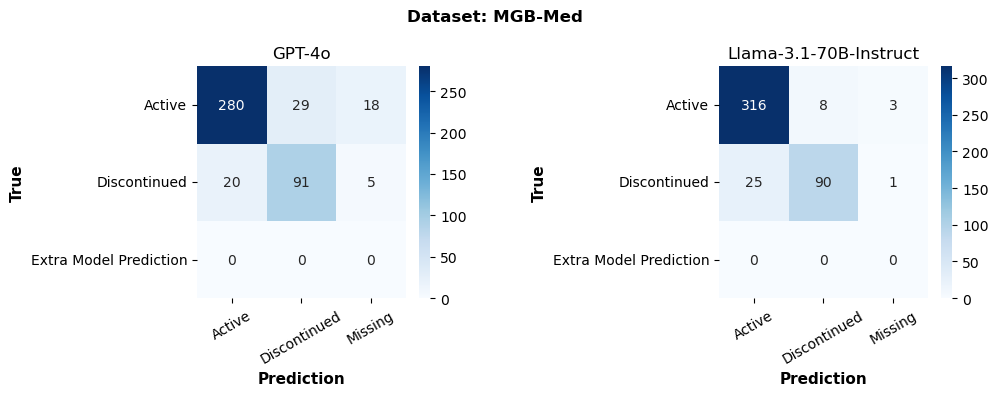

MIT Dataset


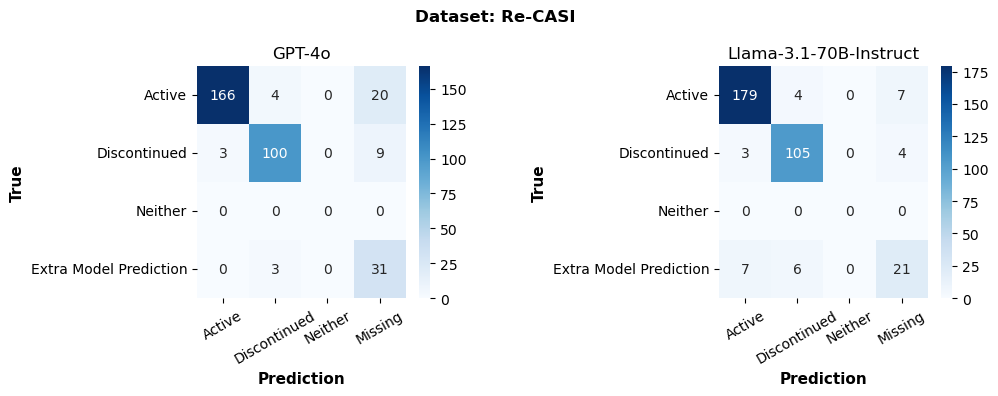

MIMIC-IV Dataset


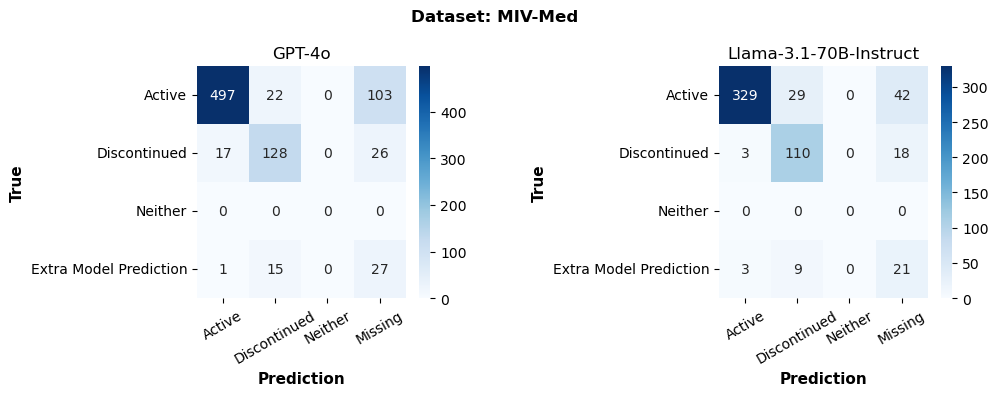

In [2]:
import pandas as pd
import numpy as np


def calculate_classification_confusion_matrix(df, dataset_name, mode = 'pure_classification'):
    """
    Calculate and aggregate TP, FP, FN, and TN counts across the dataset.

    Parameters:
        df (pd.DataFrame): The DataFrame containing 'true_set' and 'pred_set' as string representations of sets.

    Returns:
        dict: Aggregated counts for TP, FP, FN, and TN.
    """
    # Initialize confusion matrix with 'Missing' and 'Extra' rows/columns
    all_classes = ['Active', 'Discontinued', 'Neither'] if dataset_name == 'external' else ['Active', 'Discontinued']
    extended_classes = all_classes + ["Extra Model Prediction"]
    cols = all_classes + ["Missing"]
    confusion_data = pd.DataFrame(0, index=extended_classes, columns=cols)

    class_names = ['active_medications', 'discontinued_medications', 'neither_medications'] if dataset_name == 'external' else ['active_medications', 'discontinued_medications']

    # Iterate over each row
    for _, row in df.iterrows():
        # Reconstruct the true and predicted sets
        true_labels = {}
        pred_labels = {}

        # Populate true labels
        for class_name, class_label in zip(class_names, all_classes):
            for med in row[class_name]:  # Medications in this class
                true_labels[med] = class_label

        # Populate predicted labels
        for class_name, class_label in zip([f"{c}_pred" if mode == 'pure_classification' else f"{c}_pred_with_groundtruth" for c in class_names], all_classes):
            for med in row[class_name]:  # Medications in this predicted class
                pred_labels[med] = class_label

        # Get all unique medication names
        all_meds = row['true_set']
        for med in all_meds:
            true_class = true_labels.get(med, "Extra Model Prediction")  
            pred_class = pred_labels.get(med, "Missing")   

            # Increment the corresponding cell in the confusion matrix
            confusion_data.loc[true_class, pred_class] += 1
        
    confusion_data.columns.name = "Prediction"
    confusion_data.index.name = "True"
    return confusion_data

def generate_confusion_matrices_for_models(df_list, model_list, dataset_name, not_internal=False):
    """
    Generate confusion matrix heatmaps for multiple models side by side.

    Parameters:
        df_list (list of pd.DataFrame): List of dataframes for each model.
        model_list (list of str): List of model names corresponding to the dataframes.
        not_internal (bool): Indicator for dataset type (external or internal).

    Returns:
        matplotlib.figure.Figure: The figure containing all confusion matrices.
    """
    # Create a figure with subplots, one per model
    num_models = len(model_list)
    fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 4))
    
    if num_models == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one model

    for ax, model_name, df in zip(axes, model_list, df_list):
        # Calculate the confusion matrix
        if not_internal:
            confusion_matrix = calculate_classification_confusion_matrix(df, dataset_name='external', mode='pure_classification')
        else:
            confusion_matrix = calculate_classification_confusion_matrix(df, dataset_name='internal', mode='pure_classification')

        # Create the heatmap
        sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
        model_name = 'GPT-4o' if model_name == 'gpt-4o' else model_name
        ax.set_title(f'{model_name}')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    # add a overall title for the figure
    if dataset_name == 'MIT':
        dataset_name = 'Re-CASI'
    elif dataset_name == 'MIMIC-IV':
        dataset_name = 'MIV-Med'
    elif dataset_name == 'Internal Data':
        dataset_name = 'MGB-Med'
    fig.suptitle(f'Dataset: {dataset_name}', fontsize=12, fontweight='bold')
    # bold the axis label
    for ax in axes:
        ax.set_xlabel(ax.get_xlabel(), fontweight='bold', fontsize=11)
        ax.set_ylabel(ax.get_ylabel(), fontsize=11, fontweight='bold')
    
    # increase the width gap between subplots
    

    # Adjust layout for clarity
    plt.tight_layout()
    fig.subplots_adjust(wspace=1)
    
    
    return fig



# models to evaluate: GPT-4o, Llama-3.1-70B-Instruct,  Qwen2.5-72B-Instruct
# method: 0-shot

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

columns = ['active_medications', 'discontinued_medications', 'active_medications_pred',
           'discontinued_medications_pred', 'true_set', 'pred_set', 'active_medications_pred_with_groundtruth',
            'discontinued_medications_pred_with_groundtruth']

file_path = '/PHShome/cs1839/capstone_data/base_pred_data/{}_{}_sim_0_{}.csv'

models = ['gpt-4o', 'Llama-3.1-70B-Instruct']
datasets = {
    'Internal Data': False,
    'MIT': True,
    'MIMIC-IV': True,
    
}

for dataset_name, not_internal in datasets.items():
    print(f'==================================\n{dataset_name} Dataset\n==================================')
    
    df_list = []
    for model in models:
        if dataset_name == 'Internal Data':
            columns_to_read = columns
        else:
            columns_to_read = columns + ['neither_medications', 'neither_medications_pred', 'neither_medications_pred_with_groundtruth']
        
        df = pd.read_csv(file_path.format(dataset_name, model, 'Other'))[columns_to_read] if not_internal else pd.read_csv(file_path.format(dataset_name, model, 'Internal Data'))[columns_to_read]
        for col in columns:
            df[col] = df[col].apply(eval)
        df_list.append(df)
    
    fig = generate_confusion_matrices_for_models(df_list, models, dataset_name, not_internal)
    plt.show()